# Line Detection V1
1. เวอร์ชั่นนี้จะเป็นการตรวจจับบรรทัดแบบทั้งแถวเลย
2. เรียงตัวอักษรจากซ้ายไปขวา

## Histogram Projection
ใช้ Histogram Projection เพื่อแยกบรรทัดในแนวนอน:

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

output_folder = Path("../data/output_images/output_lines")
output_folder.mkdir(exist_ok=True)

# โหลดภาพ
image = cv2.imread("../data/test_images/line_detection/text4.jpg")
if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

# แปลงเป็น Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

'''
# แปลงเป็น Binary
_, binary_image = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)  # Threshold ขาวดำ
'''

# การ Threshold แบบ Adaptive Gaussian
binary_image = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,30
)

# คำนวณ Histogram Projection
horizontal_projection = np.sum(binary_image, axis=1)  # รวมพิกเซลในแนวนอน

# หาตำแหน่งที่มีข้อความ
line_indices = np.where(horizontal_projection > 0)[0]

# แยกช่วงตำแหน่งแต่ละบรรทัด
lines = []
start_idx = None

for i in range(len(line_indices) - 1):
    if start_idx is None:
        start_idx = line_indices[i]
    if line_indices[i+1] > line_indices[i] + 1:  # เจอช่วงว่างระหว่างบรรทัด
        end_idx = line_indices[i]
        lines.append((start_idx, end_idx))
        start_idx = None
if start_idx is not None:
    lines.append((start_idx, line_indices[-1]))

print("Lines detected:", lines)

# แยกบรรทัดและเพิ่ม Padding
line_images = []
padding = 5  # ระบุ Padding

for start, end in lines:
    padded_start = max(0, start - padding)
    padded_end = min(binary_image.shape[0], end + padding)
    line_img = binary_image[padded_start:padded_end, :]
    line_images.append(line_img)

for idx, line_img in enumerate(line_images):
    file_path = output_folder / f"line_{idx + 1}.png"
    cv2.imwrite(str(file_path), line_img)
print(f"Saved lines to {output_folder}")

'''
# เพิ่มเส้นกรอบรอบข้อความแต่ละบรรทัด
for start, end in lines:
    cv2.rectangle(image, (0, start), (image.shape[1], end), (0, 255, 0), 2)
cv2.imshow("Detected Lines", image)
cv2.imshow("Binary Image", binary_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# การแยกข้อความแต่ละบรรทัดออกเป็นภาพย่อย
line_images = [binary_image[start:end, :] for start, end in lines]
for idx, line_img in enumerate(line_images):
    cv2.imshow(f"Line {idx + 1}", line_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''


Lines detected: [(44, 59), (116, 131), (187, 202)]
Saved lines to ..\data\output_images\output_lines


'\n# เพิ่มเส้นกรอบรอบข้อความแต่ละบรรทัด\nfor start, end in lines:\n    cv2.rectangle(image, (0, start), (image.shape[1], end), (0, 255, 0), 2)\ncv2.imshow("Detected Lines", image)\ncv2.imshow("Binary Image", binary_image)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n\n# การแยกข้อความแต่ละบรรทัดออกเป็นภาพย่อย\nline_images = [binary_image[start:end, :] for start, end in lines]\nfor idx, line_img in enumerate(line_images):\n    cv2.imshow(f"Line {idx + 1}", line_img)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n'

## Word/Character Detection
ใช้ cv2.findContours เพื่อตรวจจับตัวอักษรหรือคำในแต่ละบรรทัด:

### แบบเก่า

In [ ]:
line_of_characters = []  # เก็บตัวอักษรทั้งหมด
i = 0
for (start_y, end_y) in lines:
    characters = []
    # ตัดภาพเฉพาะบรรทัด
    line_image = binary_image[start_y:end_y, :]
    cv2.imwrite(f"../data/test_images/line_detection/output/line_image{i}.jpg", line_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    i+=1

    # หาขอบเขตของตัวอักษรในบรรทัด
    contours, _ = cv2.findContours(line_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        
        x, y, w, h = cv2.boundingRect(contour)

        # กรองตัวอักษรที่มีขนาดเล็กเกินไป
        if w > 3 and h > 3:  # ปรับค่าตามลักษณะของตัวอักษร
            
            # เพิ่มขนาดกรอบ 20%
            margin_x = int(w * 0.3)
            margin_y = int(h * 0.3)

            # ปรับตำแหน่งและขนาดของกรอบ
            new_x = max(0, x - margin_x)
            new_y = max(0, start_y + y - margin_y)
            new_w = min(image.shape[1], x + w + margin_x) - new_x
            new_h = min(image.shape[0], start_y + y + h + margin_y) - new_y
            
            characters.append((new_x, new_y, new_w, new_h))  # บันทึกกรอบขยาย
            
    line_of_characters.append(characters)  # บันทึกกรอบขยาย

print(len(line_of_characters))      


1


In [26]:
# แสดงผลจำนวนบรรทัดและตัวอักษร
print(f"จำนวนบรรทัดตรวจจับได้: {len(line_of_characters)}")
for i, img in enumerate(line_of_characters):
    print(f"บรรทัดที่ {i+1}: x,y,w,h {line_of_characters[i]}")

จำนวนบรรทัดตรวจจับได้: 1
บรรทัดที่ 1: x,y,w,h [(783, 38, 22, 32), (752, 37, 28, 40), (723, 38, 27, 32), (680, 38, 45, 32), (653, 38, 29, 32), (623, 38, 27, 32), (572, 38, 22, 32), (550, 38, 18, 32), (514, 37, 28, 40), (483, 37, 28, 40), (448, 38, 32, 32), (418, 38, 27, 32), (371, 38, 45, 32), (304, 37, 13, 40), (289, 38, 7, 32), (221, 37, 29, 40), (168, 38, 28, 32), (108, 38, 24, 32), (46, 38, 24, 32), (599, 32, 19, 39), (309, 35, 7, 6), (289, 35, 7, 6), (358, 27, 7, 45), (326, 27, 24, 45), (253, 27, 27, 45), (200, 27, 19, 45), (135, 27, 29, 45), (76, 27, 28, 45)]


### แบบใหม่

In [29]:
import cv2
import numpy as np
from pathlib import Path

# สร้างโฟลเดอร์สำหรับเก็บตัวอักษร
output_folder = Path("../data/output_images/output_characters")  # ใช้ Path จาก pathlib
output_folder.mkdir(exist_ok=True)  # สร้างโฟลเดอร์ หากไม่มีอยู่แล้ว

char_images = []

for idx, line_img in enumerate(line_images):
    # หา Contours ในภาพแต่ละบรรทัด
    contours, _ = cv2.findContours(line_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # สร้างสำเนาภาพเพื่อวาดกรอบ
    line_with_boxes = cv2.cvtColor(line_img, cv2.COLOR_GRAY2BGR)
    
    # เรียงตัวอักษรตามตำแหน่งซ้ายไปขวา
    sorted_contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
    
    for contour in sorted_contours:
        # คำนวณกรอบสี่เหลี่ยมรอบ Contour
        x, y, w, h = cv2.boundingRect(contour)

        # เพิ่มขนาดกรอบ 10%
        padding_x = int(w * 0.1)  # เพิ่ม 10% ของความกว้าง
        padding_y = int(h * 0.1)  # เพิ่ม 10% ของความสูง

        # ปรับขอบเขตของกรอบ
        x = max(0, x - padding_x)
        y = max(0, y - padding_y)
        w = min(line_img.shape[1] - x, w + 2 * padding_x)
        h = min(line_img.shape[0] - y, h + 2 * padding_y)
        
        # กำหนดเงื่อนไขเพื่อกรอง Noise หรือกล่องเล็กเกินไป
        if 3 < w < 100 and 3 < h < 100:  # ปรับค่าขนาดขั้นต่ำและสูงสุดตามต้องการ
            # ตัดภาพตัวอักษร
            char_img = line_img[y:y+h, x:x+w]
            char_images.append(char_img)

            # บันทึกตัวอักษร
            file_path = output_folder / f"line_{idx + 1}_char_{len(char_images)}.png"
            cv2.imwrite(str(file_path), char_img)  # แปลง Path เป็น String เพื่อใช้กับ OpenCV

            # วาดกรอบสี่เหลี่ยมในภาพต้นฉบับ
            cv2.rectangle(line_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 1)

    # บันทึกภาพพร้อมกรอบตัวอักษร (ถ้าต้องการ)
    boxed_line_path = output_folder / f"line_{idx + 1}_boxed.png"
    cv2.imwrite(str(boxed_line_path), line_with_boxes)

    print(f"Line {idx + 1}: Detected {len(sorted_contours)} characters")

# รายงานผลลัพธ์
print(f"Saved {len(char_images)} characters to {output_folder}")


Line 1: Detected 10 characters
Line 2: Detected 10 characters
Line 3: Detected 8 characters
Saved 28 characters to ..\data\output_images\output_characters


### Visualization ก่อนเรียงลำดับ

In [27]:
'''
import matplotlib.pyplot as plt

idx = 3
img = cropped_images[idx]                  # image at index
plt.imshow(img, cmap=plt.cm.gray_r) # actutal BG is black (invert)
#plt.imshow(img, cmap=plt.cm.gray)  

plt.grid() 
plt.show()
'''

'\nimport matplotlib.pyplot as plt\n\nidx = 3\nimg = cropped_images[idx]                  # image at index\nplt.imshow(img, cmap=plt.cm.gray_r) # actutal BG is black (invert)\n#plt.imshow(img, cmap=plt.cm.gray)  \n\nplt.grid() \nplt.show()\n'

## Sorting (การเรียงลำดับตัวอักษร)
เรียงลำดับตัวอักษรในแต่ละบรรทัดจากซ้ายไปขวา:

In [28]:
# เรียงตัวอักษรตาม y (บรรทัด) ก่อน แล้วตาม x (ในบรรทัด)
#characters = sorted(characters, key=lambda c: (c[0]))
sorted_letters = []
for i, characters_in_line in enumerate(line_of_characters):
    sorted_letters.extend(sorted(characters_in_line, key=lambda c: (c[0])))

# ตัดภาพและเก็บในรูปแบบอาร์เรย์
cropped_images = []
for (x, y, w, h) in sorted_letters:
    cropped_image = image[y:y+h, x:x+w]  # ตัดภาพจากกรอบ
    cropped_images.append(cropped_image)  # เก็บภาพในรายการ

# แสดงผลจำนวนตัวอักษรและขนาดของ cropped images
print(f"จำนวนตัวอักษรที่ตรวจจับได้: {len(cropped_images)}")
for i, img in enumerate(cropped_images):
    #print(f"ตัวอักษรที่ {i+1}: ขนาดภาพ {img.shape}")
    print(f"ตัวอักษรที่ {i+1}: x,y,w,h {sorted_letters[i]}")

จำนวนตัวอักษรที่ตรวจจับได้: 28
ตัวอักษรที่ 1: x,y,w,h (46, 38, 24, 32)
ตัวอักษรที่ 2: x,y,w,h (76, 27, 28, 45)
ตัวอักษรที่ 3: x,y,w,h (108, 38, 24, 32)
ตัวอักษรที่ 4: x,y,w,h (135, 27, 29, 45)
ตัวอักษรที่ 5: x,y,w,h (168, 38, 28, 32)
ตัวอักษรที่ 6: x,y,w,h (200, 27, 19, 45)
ตัวอักษรที่ 7: x,y,w,h (221, 37, 29, 40)
ตัวอักษรที่ 8: x,y,w,h (253, 27, 27, 45)
ตัวอักษรที่ 9: x,y,w,h (289, 38, 7, 32)
ตัวอักษรที่ 10: x,y,w,h (289, 35, 7, 6)
ตัวอักษรที่ 11: x,y,w,h (304, 37, 13, 40)
ตัวอักษรที่ 12: x,y,w,h (309, 35, 7, 6)
ตัวอักษรที่ 13: x,y,w,h (326, 27, 24, 45)
ตัวอักษรที่ 14: x,y,w,h (358, 27, 7, 45)
ตัวอักษรที่ 15: x,y,w,h (371, 38, 45, 32)
ตัวอักษรที่ 16: x,y,w,h (418, 38, 27, 32)
ตัวอักษรที่ 17: x,y,w,h (448, 38, 32, 32)
ตัวอักษรที่ 18: x,y,w,h (483, 37, 28, 40)
ตัวอักษรที่ 19: x,y,w,h (514, 37, 28, 40)
ตัวอักษรที่ 20: x,y,w,h (550, 38, 18, 32)
ตัวอักษรที่ 21: x,y,w,h (572, 38, 22, 32)
ตัวอักษรที่ 22: x,y,w,h (599, 32, 19, 39)
ตัวอักษรที่ 23: x,y,w,h (623, 38, 27, 32)
ตัวอักษรที่ 24: x,y,

### Visualization หลังเรียงลำดับ

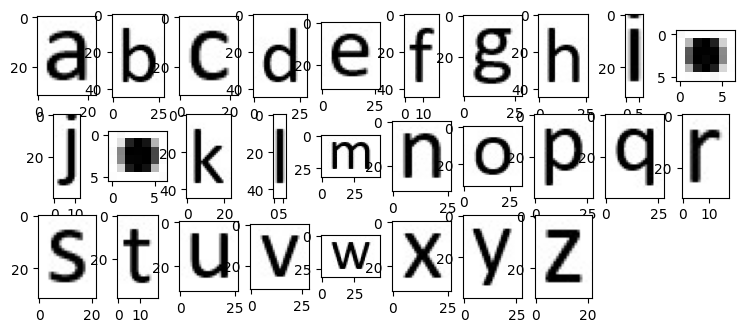

In [29]:
def visual_multi(i):
    nplots = len(cropped_images)
    fig = plt.figure(figsize=(9, 5))
    for j in range(nplots):
        plt.subplot(4, 10, j+1)
        plt.imshow(cropped_images[i+j], cmap=plt.cm.gray_r)
        #plt.title(y_train[i+j])
    
    plt.show()
visual_multi(0) # ตัวเริ่มจากเลขอะไร

## Predict
ส่งให้โมเดลทำนาย:

In [30]:
from tensorflow.keras.models import load_model

#model = load_model('model/numrals_model.h5') # Load model
#model = load_model('model/upper_end_letters_model.h5') # Load model
model = load_model('model/lower_eng_letters_model.h5') # Load model
model.summary() 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 2, 2, 128)       

In [31]:
from tensorflow.image import rgb_to_grayscale
from tensorflow.image import resize
import numpy as np

cropped_characters = []

for idx,img in enumerate(cropped_images):

    # ตัดตัวอักษร
    #cropped_char = image[y:y+h, x:x+w]
    #cropped_characters.append(cropped_char)

    # ตัวอย่างการใช้โมเดลทำนาย
    resized_char = cv2.resize(img, (32, 32))  # Resize ให้ตรงกับ input ของโมเดล

    # ตรวจสอบว่าภาพเป็น RGB หรือไม่
    if resized_char.shape[-1] == 3:  # ถ้าเป็นภาพสี
        grayscale_image = rgb_to_grayscale(resized_char)
    else:
        grayscale_image = resized_char[..., np.newaxis]  # เพิ่มแกนช่องสี

    normalized_char = grayscale_image / 255  # Normalize

    #input_char = np.expand_dims(normalized_char, axis=-1)  # เพิ่ม Batch และ Channel Dimension
    input_char = np.expand_dims(normalized_char, axis=0)

    prediction = model.predict(input_char)
    predicted_label = np.argmax(prediction)
    confidence = np.max(prediction) * 100
    print(f"No: {idx} | Predicted: {predicted_label} | {confidence.round(2)} %")
    #print(f"Predicted: {predicted_label} | {prediction.round(2)} %")

1/1 [==============================] - 0s 158ms/step
No: 0 | Predicted: 3 | 99.82 %
1/1 [==============================] - 0s 24ms/step
No: 1 | Predicted: 1 | 100.0 %
1/1 [==============================] - 0s 19ms/step
No: 2 | Predicted: 2 | 100.0 %
1/1 [==============================] - 0s 18ms/step
No: 3 | Predicted: 3 | 100.0 %
1/1 [==============================] - 0s 21ms/step
No: 4 | Predicted: 6 | 51.43 %
1/1 [==============================] - 0s 19ms/step
No: 5 | Predicted: 5 | 100.0 %
1/1 [==============================] - 0s 19ms/step
No: 6 | Predicted: 4 | 98.76 %
1/1 [==============================] - 0s 17ms/step
No: 7 | Predicted: 7 | 99.97 %
1/1 [==============================] - 0s 20ms/step
No: 8 | Predicted: 20 | 85.98 %
1/1 [==============================] - 0s 17ms/step
No: 9 | Predicted: 20 | 55.03 %
1/1 [==============================] - 0s 16ms/step
No: 10 | Predicted: 3 | 100.0 %
1/1 [==============================] - 0s 16ms/step
No: 11 | Predicted: 22 | 68.37 

In [32]:
for (x, y, w, h) in characters:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

cv2.imshow("Detected Characters", image)
cv2.waitKey(0)
cv2.destroyAllWindows()